# Predictor Evaluation and Visualization

This notebook includes tools to load existing models and detections data, generate sequences from the data, and evaluating and visualizing the models and data.

The main drawback of this notebook is the memory constraints: it loads all of the data from the different files of the experiements, which is bounded by the machine's RAM. The document lists some solutions that could be implemented to alliveate this issue.

## Imports

In [2]:
import os
os.chdir('/app/Pogona_realtime/Arena') # change the working directory of the notebook

In [3]:
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import seaborn as sns
from tqdm.auto import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv
from scipy.stats import pearsonr

from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib
from Prediction import traj_models

In [51]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)
imp.reload(traj_models)

<module 'Prediction.traj_models' from '/app/Pogona_realtime/Arena/Prediction/traj_models.py'>

## Load data

Loads the entire detections data into a dataframe, bounded by the avavliable memory on the machine.

The options are the different sources of data that could be loded: the detections data itself, the timestamps of the camera recordings and and the screen touchings. If 'touches' is true, then timestamps must be true as well. 

'dlc' is supposed to align some of the offline DLC analysis with the frames, but the data need to be produced, so it will probably won't work in the future.

In [4]:
all_df = pd.read_csv("dataset20201122.csv.gz", index_col=0)

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
all_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 1747318 entries, line_20200803T081429_trial1 to red_beetle_anticlock_20201104T145900_trial1
Data columns (total 17 columns):
 #   Column    Dtype  
---  ------    -----  
 0   cent_x    float64
 1   cent_y    float64
 2   x1        float64
 3   y1        float64
 4   x2        float64
 5   y2        float64
 6   conf      float64
 7   num_bbox  float64
 8   frame_ts  object 
 9   hit_x     float64
 10  hit_y     float64
 11  bug_x     float64
 12  bug_y     float64
 13  is_hit    bool   
 14  touch_ts  object 
 15  is_touch  bool   
 16  bug_ts    object 
dtypes: bool(2), float64(12), object(3)
memory usage: 593.6 MB


In [6]:
trials = all_df.index.unique()

### Filter Data

Generate Kalman filtered detections for the bounding box corners

In [136]:
for trial in tqdm(all_df.index.unique()):
    filtered = kalman_predict.filter_trial(all_df.loc[trial], cols=['x1', 'y1'])
    all_df.loc[trial, ['flt_x1', 'flt_y1']] = filtered

    filtered = kalman_predict.filter_trial(all_df.loc[trial], cols=['x2', 'y2'])
    all_df.loc[trial, ['flt_x2', 'flt_y2']] = filtered


100%|██████████| 223/223 [01:41<00:00,  2.19it/s]


## Load Trajectory Predictors

Choose which seq2seq models, produced with the predictor_train notebook, should be build and loaded. The names to be provided are the names from the models_params JSON file, without the 'final' or 'best' suffix. By default, the model with the lowest validation set ADE is chosen.
The models need to have the same input-output lengths, otherwise an error will occur.

The initialized seq2seq models are stored in a list.

In [7]:
#model_names = ['RNN_GRU_1023-1208_i20_o20_h32_l1', 'RNN_GRU_1023-1145_i20_o20_h700_l1_long']
#model_names = ['RNN_GRU_1023-1208_i20_o20_h32_l1', 'RNN_GRU_1023-1259_i20_o20_h200_l2', 'RNN_GRU_1023-1309_i20_o20_h600_l3'][:1]
#model_names = ['RNN_GRU_1023-1701_i20_o20_h350_l1_RealExtreme', 
#               'RNN_GRU_1023-1551_i20_o20_h350_l1_NoMask','RNN_GRU_1022-2019_i20_o20_h350_l1_long'][-1:]
#model_names = ['Linear_GRU_1022-1056_i20_o20_h350_l1', 'RNN_GRU_1023-1701_i20_o20_h350_l1_RealExtreme']
model_names = ['RNN_GRU_1022-2019_i20_o20_h350_l1_long', 'RNN_GRU_1023-1701_i20_o20_h350_l1_RealExtreme']

In [8]:
seq2seq_models = []
for model_name in model_names:
    net, model_params = traj_models.get_model(model_name)
    traj_predictor = seq2seq_predict.Seq2SeqPredictor(model=net, 
                                                      weights_path=traj_models.get_weights_path(model_name),
                                                      input_len=model_params['network_params']['inp_seq_len'],
                                                      forecast_horizon=model_params['network_params']['out_seq_len'])
    traj_predictor.model_params = model_params
    seq2seq_models.append(traj_predictor)

RuntimeError: CUDA error: out of memory

In addition, a kalman filter predictor can be generated and appended to the seq2seq predictors list

In [8]:
# Kalman Trajectory Predictor
kalman_predictor = kalman_predict.KalmanPredictor(forecast_horizon=20, 
                                                  num_derivatives=1, 
                                                  q_var=2.145, r_var=120.0)

## Predictor timings

Test the loaded predictors inference time and plot the results

In [9]:
def seq2seq_name(traj_pred):
    inp_len = traj_pred.model_params['network_params']['inp_seq_len']
    out_len = traj_pred.model_params['network_params']['out_seq_len']
    decoder_type = traj_pred.model_params['network_params']['decoder_type']
    rnn_type = traj_pred.model_params['network_params']['rnn_type']
    rnn_layers = traj_pred.model_params['network_params']['rnn_layers']
    hidden_size = traj_pred.model_params['network_params']['hidden_size']
    return f'Dec:{decoder_type}, RNN:{rnn_type}, l:{rnn_layers}, h:{hidden_size}, {inp_len}-{out_len}'

In [10]:
def seq2seq_complexity_name(traj_pred):
    rnn_layers = traj_pred.model_params['network_params']['rnn_layers']
    hidden_size = traj_pred.model_params['network_params']['hidden_size']
    return f'l:{rnn_layers}, h:{hidden_size}'

In [ ]:
K = 5000

rand_bboxes = np.random.random((K, 4))

timings = []
for traj_pred in seq2seq_models + [kalman_predictor]:
    results, _ = train_eval.eval_trajectory_predictor(traj_pred, rand_bboxes, show_progress=False)
    times_arr = np.array(results['times'])
    timings.append(times_arr)

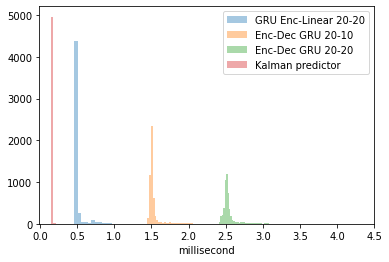

In [26]:
%matplotlib inline

thresh = 0.005
bins_list = [50,50,50,5]
labels = ["GRU Enc-Linear 20-20", "Enc-Dec GRU 20-10", "Enc-Dec GRU 20-20", "Kalman predictor"]
for traj_pred, times, bins, label in zip(seq2seq_models + [kalman_predictor], timings, bins_list, labels):
    """
    
    if traj_pred == kalman_predictor:
        label = "Kalman predictor"
    else:
        label = seq2seq_name(traj_pred)
    """
    sns.distplot(times[times < thresh]*1000, bins=bins, kde=False, label=label)

plt.legend()
plt.xticks(np.arange(0, thresh*1000, 0.5))
plt.xlabel('millisecond')
#plt.ylim((0, 1500))
plt.savefig('../experiments_plots/all_timings.png', dpi=200)

## Sequences data
Generate the 3D sequence tensor data from the detections dataframe. The paramerters for the sequence length are determined by the models loaded earlier.

### Custom masking
The masking is used to evaluate on only a subset of the sequences data. The mask could be manually defined in the cell below, by setting the lower and upper bound on various statistics computed on the each sequence, or by using the masking defined for a loaded model.

In [11]:
INF_P = 9999999

mask_dict_alt = {
    'fl_dist': [0, INF_P, True, True], # min, max, mask_X, mask_Y
    'speed': [0, INF_P, True, True],
    'std': [0.0, INF_P, [0,1]],
    'corr': [0.0, 1.0, True, True],
    'zgzg': [0.0, 1.5, True, True],
    'keep_prob': 0.0
}

In [12]:
# use custom masking dict
mask_dict = mask_dict_alt

In [12]:
# use masking dict that model was trained on
mask_dict = seq2seq_models[0].model_params['masking_params']

In [13]:
# mask_fn is a function that opreates on 3D sequence tensors, and returns a boolean mask (1D boolean array)
mask_fn = train_eval.compose_masks(mask_fns=[
    train_eval.mask_fl_dist(*mask_dict['fl_dist']),
    train_eval.mask_speed(*mask_dict['speed']),
    train_eval.mask_std(*mask_dict['std']),
    train_eval.mask_corr(*mask_dict['corr']),
    train_eval.mask_zgzg(*mask_dict['zgzg'])
    ], invert=False)

### Create trials dict
The sequences generated from each trial are first stored in a dictionary, that contains all of the sequences without masking, and the boolean mask for the trial itself. That way, the masked data can be acssessed on the fly, and updating the masking parameters does not require to compute the sequences again, only the mask. 

In [14]:
# run only in initailization of notebook
np.warnings.filterwarnings('ignore')

net_params = seq2seq_models[0].model_params['network_params']
trials_dict = train_eval.create_samples(df=all_df,
                                        mask_fn=mask_fn,
                                        keep_prob=mask_dict['keep_prob'],
                                        input_labels=net_params['input_labels'], output_labels=net_params['output_labels'], 
                                        input_seq_size=net_params['inp_seq_len'], output_seq_size=net_params['out_seq_len'],
                                        keep_nans=True)

np.warnings.filterwarnings('default')

In [34]:
# run when masking is updated
np.warnings.filterwarnings('ignore')

train_eval.update_trials_dict(trials_dict, mask_fn, keep_prob=mask_dict['keep_prob'])

np.warnings.filterwarnings('default')

The sequences data is split according to individual trials. The train-validation-test split can be loaded from file, or re-computed. The split aims that each of the parts of the split has relatively equal proportion of sequences that pass the boolean mask. It is done by computing the ratio between the number of sequences that passed the mask, and the total number of sequences in that trial, sorting the trials according to these ratios, spliting the trials into batches, and selecting trials from each batch into the training, validation and test sets according to the split ratio.

In [489]:
# create new split of the trials
train_trials, val_trials, test_trials = train_eval.split_train_val_test(trials_dict, split=(1.0, 0, 0))

In [15]:
# use existing split from the model
train_trials = seq2seq_models[0].model_params['training_params']['train_trials']
val_trials = seq2seq_models[0].model_params['training_params']['val_trials']
test_trials = seq2seq_models[0].model_params['training_params']['test_trials']

After generating the trials sequence dictionary and the trials split, the training, validation and test datasets can be generated. They are Pytorch DataLoaders, used for iterating over the datasets in batches. The entire 3D Pytorch tensors can be also accessed.

In [16]:
# create dataloaders for batch inference
batch_size = 128
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(trials_dict, train_trials, val_trials, test_trials,
                                                                         train_mask=False, val_mask=False, test_mask=False,
                                                                         batch_size=batch_size, shuffle=False)

print("Sample size:")
print(f"Training: {len(train_trials)} trials, {len(train_dl.dataset)} seqs")
if val_dl is not None:
    print(f"Validation: {len(val_trials)} trials, {len(val_dl.dataset)} seqs")
if test_dl is not None:
    print(f"Test: {len(test_trials)} trials, {len(test_dl.dataset)} seqs")

Sample size:
Training: 159 trials, 813644 seqs
Validation: 32 trials, 161626 seqs
Test: 32 trials, 182975 seqs


### Generate data tensors and predictions
After generating the dataloaders, the predictions for each sequence can be generated and stored in 3D tensor, where the indices are the same as the Y sequences tensor.

In [18]:
# create numpy 3d-arrays of the data
dl = test_dl
seq_data_X = dl.dataset.X.numpy()
seq_data_Y = dl.dataset.Y.numpy()
print(f'Combined memory of X and Y tensors: {seq_data_X.nbytes/2**20 + seq_data_Y.nbytes/2**20:.1f} MB')

Combined memory of X and Y tensors: 111.7 MB


In [19]:
seq_preds = []
for traj_pred in seq2seq_models:
    seq_preds.append(train_eval.get_seq_forecast(dl, traj_pred.model))

In [20]:
ADEs, FDEs, trial_lens, all_forecasts = train_eval.eval_traj_predictor_on_trials(test_trials, kalman_predictor, all_df)
seq_pred_kalman = train_eval.all_forecasts_to_seq_data(all_forecasts, inp_seq_len=net_params['inp_seq_len'], 
                                                            out_seq_len=net_params['out_seq_len'],
                                                            out_dim=net_params['output_dim'])

### Compare ADE of models
After generating the predictions, the average ADE of each predictor can evaluated on the test set

In [20]:
np.warnings.filterwarnings('ignore')


bar_df = pd.DataFrame()
mask = mask_fn(seq_data_X, seq_data_Y)
nan_mask_Y = ~np.isnan(seq_data_Y).any(axis=2).any(axis=1)
nan_mask_X = ~np.isnan(seq_data_X).any(axis=2).any(axis=1)
nan_mask = nan_mask_Y & nan_mask_X
for seq_pred, traj_pred in zip(seq_preds + [seq_pred_kalman], seq2seq_models + [kalman_predictor]):
    ADE = train_eval.calc_ADE(torch.from_numpy(seq_pred[nan_mask]), torch.from_numpy(seq_data_Y[nan_mask]))
    masked_ADE = train_eval.calc_ADE(torch.from_numpy(seq_pred[mask]), torch.from_numpy(seq_data_Y[mask]))
    
    if traj_pred == kalman_predictor:
        name = 'Kalman'
    else:
        name = seq2seq_name(traj_pred)
    
    bar_df.loc[name, 'False'] = ADE.item()
    bar_df.loc[name, 'True'] = masked_ADE.item()
np.warnings.filterwarnings('default')

In [21]:
bar_df['Model'] = bar_df.index

long_df = pd.melt(bar_df,id_vars=['Model'], var_name='Masking',value_name='ADE', ignore_index=False)

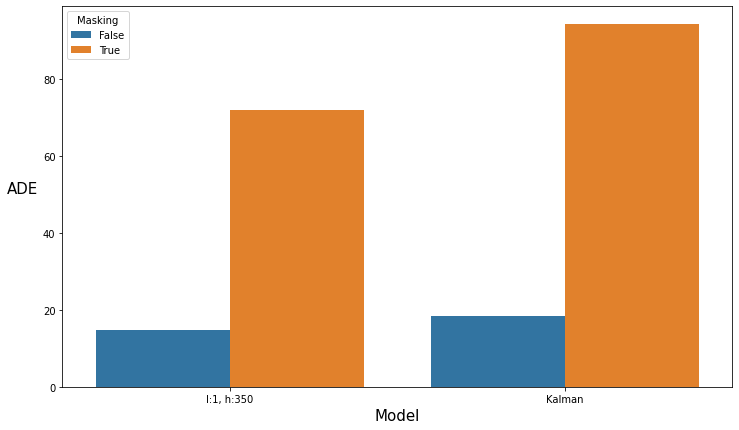

In [28]:
%matplotlib inline
plt.figure(figsize=(12,7))
sns.barplot(x='Model',y='ADE',hue='Masking',data=long_df)
plt.ylabel('ADE',fontsize=15, rotation=0,labelpad=20)
plt.xlabel('Model',fontsize=15)

plt.savefig('../experiments_plots/ADEs_bar.jpg',dpi=200)

### Generate hits data tensors and predictions

In [373]:
def seqs_contain_hits(df, trials, inp_len, out_len ,steps2hit=0 ,stride=1):

    seq_X_list = []
    seq_Y_list = []
    loc_list = []
    for trial_i, trial in enumerate(trials):
        
        temp = df.loc[trial]
        touches = temp.is_touch
        
        if touches.sum() == 0:
            continue
        hits_ind = np.where(touches)[0]

        for j, hit_ind in enumerate(hits_ind):
            for i in range(steps2hit, out_len, stride):
                # slice inp_seq and out_seq
                inp_min = hit_ind - i - inp_len - 1
                inp_max = hit_ind - i - 1
                out_min = inp_max + 1
                out_max = out_min + out_len
                
                if inp_min < 0 or out_max > temp.shape[0]:
                    continue
                
                inp_seq = temp.iloc[inp_min: inp_max][['x1','y1', 'x2', 'y2']].values
                out_seq = temp.iloc[out_min: out_max][['x1','y1', 'x2', 'y2']].values
                
                seq_X_list.append(inp_seq)
                seq_Y_list.append(out_seq)
                loc_list.append((trial_i, out_min))
                
    return np.stack(seq_X_list), np.stack(seq_Y_list), loc_list

hits_X, hits_Y, loc_list = seqs_contain_hits(all_df, all_df.index.unique(), 20, 20, steps2hit=8, stride=1)

#hits_preds = [train_eval.get_seq_forecast(train_eval.DataLoader(train_eval.TrajectoriesData(hits_X, hits_Y),batch_size=128), s2s.model) for s2s in seq2seq_models]
#hits_preds_kalman = np.stack([all_forecasts[i][t] for (i, t) in loc_list])

### Visualize sequences and predictions
In addition to the quantitative results (test set ADE), the models can also be compared qualititavely by visualizing the trajectories and the predictions of each model. This allows for a more fine-grained analysis of the predictor's behavior and various shortcomings. 

In [21]:
# visualize general sequences
seq_X = seq_data_X
seq_Y = seq_data_Y
preds = seq_preds + [seq_pred_kalman]

In [374]:
# visualize only hit sequences
seq_X = hits_X
seq_Y = hits_Y
#preds = hits_preds + [hits_preds_kalman]

This cell samples some trajectories at random, as plotting the entire trajectories is both computationally intensive and not helpful

In [19]:
 # costly to recompute each time, run only if mask_fn was updated
np.warnings.filterwarnings('ignore')

data_mask = mask_fn(seq_X, seq_Y)

np.warnings.filterwarnings('default')

In [23]:
%matplotlib widget
#%matplotlib inline

N_samples = 10
draw_preds = True

fig,ax = plt.subplots(1,1,figsize=(8,14))

im = cv.imread('../pogona_frames/transformed_image.jpg')
im = cv.convertScaleAbs(im, alpha=2.5,beta=-128)
ax.imshow(im,alpha=0.15)

colors = plt.get_cmap('tab10').colors[:2] + plt.get_cmap('tab10').colors[4:] 

sampling_mask = np.random.choice(np.argwhere(data_mask).squeeze(), size=N_samples)
#sampling_mask = np.random.choice(np.arange(seq_X.shape[0]), size=N_samples)
sample_X = seq_X[sampling_mask]
sample_Y = seq_Y[sampling_mask]

l_alpha = 0.5

visualize.draw_sequences(arr_X=sample_X,
           arr_Y=sample_Y,
           arr_pred=None,
           ax=ax,
           sctr_s=1,
           l_alpha=l_alpha,
           sctr_alpha=0.75,
           draw_diffs=False)

if draw_preds:
    for i, (seq_pred, traj_pred) in enumerate(zip(preds, 
                                                   seq2seq_models + [kalman_predictor])):

        if traj_pred in [kalman_predictor] :
            name = 'Kalman'
        else:
            name = seq2seq_name(traj_pred)
        

        sample_pred = seq_pred[sampling_mask]

        visualize.draw_sequences(arr_X=None,
                       arr_Y=sample_pred,
                       arr_pred=None,
                       ax=ax,
                       sctr_s=1,
                       l_alpha=l_alpha,
                       sctr_alpha=0.75,
                       draw_diffs=False,
                       ylabel=name,
                       ftr_c=colors[i % len(colors)],
                      )


#ax.axis('equal')
#txt_color = 'white'
ax.set_title(f'Input: {net_params["inp_seq_len"]}, Output: {net_params["out_seq_len"]} || {data_mask.sum():,} sequences',fontsize=13)
fig.set_facecolor(color='w')
ax.legend()

#plt.savefig("../experiments_plots/sequence_sample.png", dpi=200)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Sequence data stats
The next cells analyze and visualize distributions of the sequence data

In [492]:
def plot_distribution(ax, 
                   data_array,
                   label,
                   min_thresh=None, max_thresh=None,
                   title=None,
                   kde=True, bins=500, color='b',
                   quantiles=[0.1, 0.25, 0.5, 0.75]):
    
    mask = np.array([True] * data_array.shape[0])
    if min_thresh:
        min_mask = data_array > min_thresh
        mask = mask & min_mask
    if max_thresh:
        max_mask = data_array < max_thresh
        mask = mask & max_mask     
        
    sns.distplot(data_array[mask], label=label, kde=kde, bins=bins,ax=ax, color=color)
    ax.set_xlabel(label, fontsize=16, labelpad=5)
    
    if quantiles is not None:
        bins, vals = np.histogram(data_array[mask], bins=bins)
        top = np.max(bins)
        for q in quantiles:
            quan_val = np.quantile(data_array[mask].dropna(), q)
            ax.plot(np.ones(2) * quan_val, [0,top-top//50], linestyle='--', color='r', linewidth=1, alpha=0.5)
            ax.text(quan_val, top, q, fontsize=10, rotation=0, color='r')
                
    
    #ax.legend()
    if title:
        ax.set_title(title)


In [493]:
#funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
funcs = [train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]

#labels = ['distance', 'speed','zigzagity', 'pear_r']
labels = ['speed','zigzagity', 'pear_r']

distr_X_full = {key:pd.Series(func(seq_data_X), name=key) for key,func in zip(labels, funcs)}
distr_pred_full = {key:{model:pd.Series(func(seq_pred), name=key) for (model, seq_pred) in zip (model_names, seq_preds)} for key,func in zip(labels, funcs)}

/app/Pogona_realtime/Arena/Prediction/train_eval.py:773: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(dotprods / (u_norm * v_norm))


In [68]:
funcs = [train_eval.compute_dists, train_eval.compute_speeds, train_eval.compute_zigzagity, train_eval.compute_batch_r]
labels = ['distance', 'speed','zigzagity', 'pear_r']
distr_X_hits = {key:pd.Series(func(hits_X[:,:,2:]),name=key) for key,func in zip(labels, funcs)}

In [31]:
model_names

['RNN_GRU_1022-2019_i20_o20_h350_l1_long']

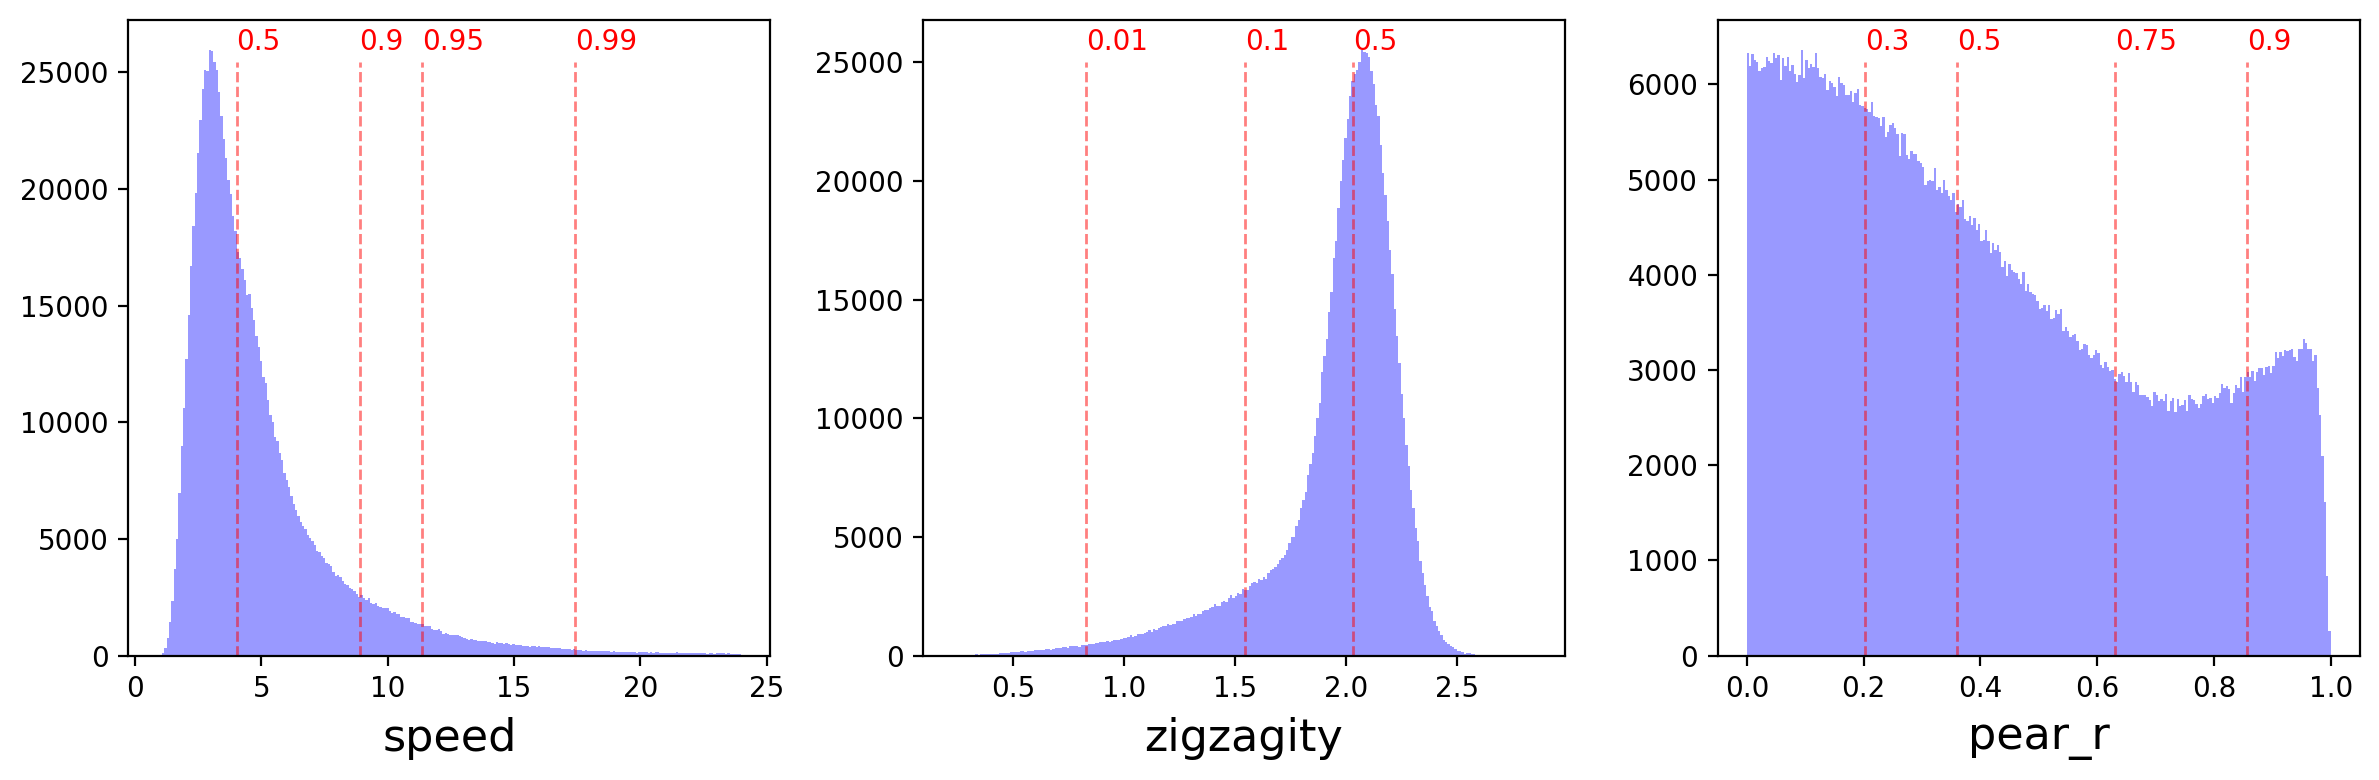

In [501]:
%matplotlib inline
preety_labels = {'speed': 'Speed', 'zigzagity':'Zigzagity', 'pear_r':"Pearson's r"}
labels_quantiles = {'speed': [0.5, 0.9, 0.95, 0.99], 
                    'zigzagity':[0.01,  0.10, 0.5], 
                    'pear_r': [0.3, 0.5, 0.75, 0.9]}

fig, axes = plt.subplots(1, len(funcs), figsize=(12,4), dpi=200)

model ='RNN_GRU_1022-2019_i20_o20_h350_l1_long'

for ax, label in zip(axes, labels):
    max_thresh = 24
    """
    plot_distribution(ax, 
                      distr_pred_full[label][model], 
                      label=label,
                      kde=False,
                      bins=250, max_thresh=max_thresh, quantiles=None)

    """
    plot_distribution(ax, 
                      distr_X_full[label], 
                      label=label,
                      kde=False,
                      bins=250, color='b',max_thresh=max_thresh, quantiles=labels_quantiles[label])
#fig.suptitle('Data statitstics', fontsize=20)
fig.tight_layout()
#axes[0].legend()
#axes[0].set_xlabel('Speed')

fig.savefig('../experiments_plots/data.jpg',dpi=200)


In [42]:
model_params['masking_params']

{'fl_dist': [0, 9999999, True, True],
 'speed': [0, 9999999, True, True],
 'std': [0.0, 9999999, [0, 1]],
 'corr': [0.0, 1.0, True, True],
 'zgzg': [0, 1.5, True, True],
 'keep_prob': 0.01}

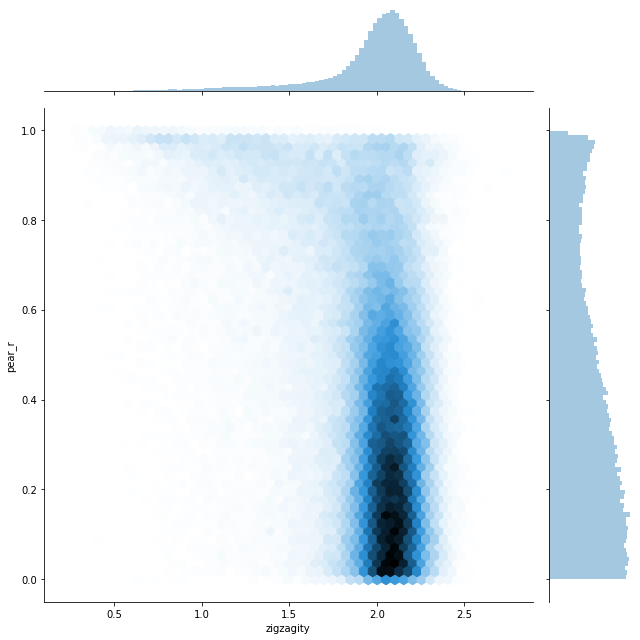

In [39]:
%matplotlib inline
# plot 2d relationship
x_axis = 'zigzagity'
y_axis = 'pear_r'
alpha = 1
color='r'

#plt.figure()
#fig, ax = plt.subplots(1,1,figsize=(12,6))
#sns.scatterplot(distr_X_full[x_axis], distr_X_full[y_axis], ax=ax, alpha=alpha,color=color)
g = sns.jointplot(distr_X_full[x_axis], distr_X_full[y_axis], kind='hex',alpha=alpha,marginal_kws={'bins':100}, height=9)
#fig.set_facecolor('w')
g.savefig('../experiments_plots/zgzg_r_data.jpg')

## Evaluate Hit Predictor
After generating the predictions, the hit predictor can be evaluted. The following cells use the ground truth prediction (if they were loaded with the all_df dataframe), to evalute how good are the hit predictions based on the trajectory predictions. Currently its donw by plotting the ground truth events with the hit predictions, more metrics, visulizations and tools should be devised to investigate this data.

### Hit predictor functions

In [22]:
# find start and end indices for each test trial in sequence arrays

trials_slicing = dict()
ind = 0
for trial in test_trials:
    trial_inds = np.argwhere(all_df.index == trial)
    start = trial_inds[0 + net_params['inp_seq_len'] - 1][0]
    end = trial_inds[-net_params['out_seq_len']][0]
    
    trial_len = end - start
    
    trials_slicing[trial] = (ind, ind + trial_len)
    ind += trial_len

In [265]:
hit_trials = ['linear_classification_20201021T115143_trial4']
hit_df = all_df.loc[hit_trials]

In [387]:
lots_o_touches = 'circle_20200803T115839_trial1'
lots_o_touches2 = 'fast_cockroach_20200803T085738_trial1'

In [266]:
# TODO: aligning with true touching events won't work, check FIRST_FRAME parameter from evaluate trajectory predictor cell

def get_hit_preds_forecasts(seq_pred_trial, 
                            hit_pred,
                            inp_len,
                            return_mean=False):
    """
    Receive an array of forecasts, and generate an array describing the hit predictions from the frame perspective,
    i.e, for each frame, there's a row of length forecast_horizon, with a value in the index of a forecast that 
    predicted a hit. (if forecast 1234 predicted hit in 5 frames, then pred[1239,5] has a value).
        
    If return_mean is true, will count the number of forecasts predicting a hit for a specific frame, and the mean predicted
    x value.
    """
    if np.all(np.isnan(seq_pred_trial)):
        print("No forecasts in list")
        return
    
    forecast_horizon = seq_pred_trial.shape[1]
    preds = np.empty((seq_pred_trial.shape[0] + forecast_horizon, forecast_horizon))    
    preds[:] = np.nan
    
    for i, forecast in enumerate(seq_pred_trial):
        x, hit_ind = hit_pred.predict_hit(forecast)
        if hit_ind is not None and hit_ind < preds.shape[0]:
            frame_ind = inp_len - 1 + (i+1) + hit_ind #  the frame index to which the hit is predicted
            preds[frame_ind, hit_ind] = x  # place the x value in the index that the forecast predicted

    
    if return_mean:
        temp = np.empty((preds.shape[0], 2))
        temp[:,0] = (~np.isnan(preds)).sum(axis=1) # number of forecasts predicting hit
        temp[:, 1] = np.nanmean(preds,axis=1)
        return temp
    return preds


def plot_preds_and_truth(preds, 
                         trial_slice, 
                         ax,
                         start=None, 
                         end=None,):
    """
    preds - a frame prediction array
    trial_slice - the slice from the dataframe for that trial, sliced like the bboxes array
    which the traj predictor operated on.
    Caller's responsibility to make sure the arrays are the same shape on dim 0 and that 
    they are aligned.
    """
    
    hits = False
    
    if start is None:
        start = 0
    if end is None:
        end = preds.shape[0]
    
    ax.set_xticklabels(np.arange(start=start, stop=end+1)) # ax.set_xticks set the integer indices of the labels
    
    preds = preds[start:end]
    trial_slice = trial_slice.iloc[start:end]
    
    forecast_horizon = preds.shape[1]
    if trial_slice is not None:
        hits_idx = np.where(trial_slice.is_touch)[0]
    
        if hits_idx.shape[0] == 0:
            print("no real hits")
        else:
            hits = True
    
    if np.all(np.isnan(preds)):
        print("All nan, nothing to show")
        return
    sns.heatmap(preds.transpose(), ax=ax, cmap='winter')
        
    curr_x_ticks = list(ax.xaxis.get_ticklabels())
    stride = int(curr_x_ticks[1].get_text())
    ax.set_xticklabels(np.arange(start=start, stop=end+1,step=stride), rotation=30) # ax.set_xticks set the integer indices of the labels
    tick_freq = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % tick_freq != 0:
            label.set_visible(False)
        
    if hits:
        for x in hits_idx:
            ax.plot(np.ones(2)*x, np.linspace(0,20,num=2), linestyle='--',linewidth=1.5, color='r', zorder=-1, alpha=0.5) 
    
   

### Hit predictions raster plot
See functions documentation for explanation of the raster plots

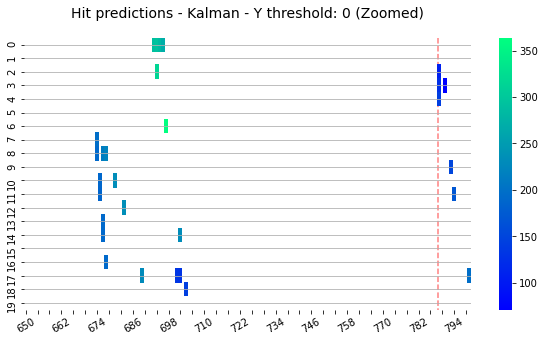

In [310]:
trial = 'line_20200803T081429_trial1'
y_thresh = 0
start = 650
end = 800
zoom = True

seq_trial_slice = trials_slicing[trial]
seq_pred_trial = seq_pred_kalman[seq_trial_slice[0]: seq_trial_slice[1]]

hit_preds = get_hit_preds_forecasts(seq_pred_trial=seq_pred_trial,
                                    hit_pred=predictor.HitPredictor(None, prediction_y_threshold=y_thresh),
                                    inp_len=net_params['inp_seq_len'],
                                    return_mean=False)

#%matplotlib widget
%matplotlib inline
fig, ax1 = plt.subplots(1,1,figsize=(10,5))
plot_preds_and_truth(hit_preds,
                     all_df.loc[trial],
                     ax1,
                     start=start,
                     end=end)
plt.grid(axis='y')

fs = 14
pad = 20

if zoom:
    s2 = "(Zoomed)"
else:
    s2 = ''
s = f"Hit predictions - Kalman - Y threshold: {y_thresh} {s2}"
plt.title(s, fontsize=fs, pad=pad)
plt.savefig('../experiments_plots/'+trial+"_"+s+'.jpg', dpi=200)

## Video Visualization

### Select trial for videos

In [66]:
test_fast_trials = ['learning_20200917T152238_trial2', 'learning_20201001T084647_trial1',
                   'circle_20200803T090615_trial1', 'circle_20201019T094116_trial1']

In [67]:
trial = test_fast_trials[1]

homography = dataset.homography_for_trial(trial)
correction_fn = visualize.get_correction_fn(homography,1920)
vid_path = dataset.get_trial_video_path(trial)

### Produce predictors video

Draws various visualization over the selected trial video: bbox, centroid, past and future trajectories, and predicted trajectories.

In [65]:
# parameters
y_thresh = 10
start_frame = 0
end_frame = None
colors = [(0,255,0), (255,255, 0), (0,255,255)]  # bgr colors
past_color = (255, 0, 0)
future_color = (0, 0, 255)
dot_radius = 4
line_thickness = 2
video_width = 1280
out_path = f'../labelled/{trial}_preds.mp4'
############

hit_predictors = [predictor.HitPredictor(p, None, prediction_y_threshold=y_thresh) for p in [kalman_predictor] + seq2seq_models]
bboxes = all_df.loc[trial][['x1', 'y1', 'x2', 'y2']].values
num_frames = end_frame - start_frame if end_frame is not None else None

predictor_visualizers = [
    visualize.offline_predictor_visualizer(
        p, 
        bboxes, 
        prediction_color=c,
        hit_color=c,
        dot_radius=dot_radius,
        line_thickness=line_thickness) for p, c in zip(hit_predictors, colors)
]

visualize.process_video(
    video_path=vid_path,
    output_path=out_path,
    process_fns=(
        [visualize.offline_trajectory_visualizer(
             bboxes,
             past_color=past_color,
             future_color=future_color,
             dot_radius=dot_radius,
             past_length=net_params['inp_seq_len'],
             future_length=net_params['out_seq_len']
         ),
         visualize.offline_bbox_visualizer(
             bboxes, 
             color=(0, 0, 0), 
             line_thickness=line_thickness,
             window_size=1
         ),
        visualize.offline_centroid_visualizer(
              bboxes, 
              color=(0, 0, 0), 
              dot_radius=dot_radius*2,
              window_size=1
          ),
         ] +         
        predictor_visualizers 
    ),
    correction_fn=correction_fn,
    start_frame=start_frame,
    num_frames=num_frames,
    resize_to_width=video_width
)

### Video sequence widget

An interactive widget to explore trajectories and predictions along the source video frames.

In [58]:
start, end = trials_slicing[trial]
X_trial = seq_X[start : end]
Y_trial = seq_Y[start : end]

np.warnings.filterwarnings('ignore')
trial_mask = mask_fn(X_trial, Y_trial)
np.warnings.filterwarnings('default')
passed_mask = trial_mask.sum()
print(f'{passed_mask} masked out of {X_trial.shape[0]}')

52 masked out of 8770


In [59]:
def seq4_to_middle(seq_data):
    """xyxy bbox to center bottom edge coordinates"""
    squeeze = False
    if len(seq_data.shape) == 2:
        squeeze = True
        seq_data = seq_data[None, :, :]
    
    # get (batch, seq, 4), xyxy, return (batch, seq, 2) xy, where x (x1+x2)/2
    X1, Y1, X2, Y2 = 0, 1, 2, 3
    ret = np.stack([(seq_data[:,:,X1] + seq_data[:,:,X2])/2, seq_data[:,:,Y2]], axis=2)
    if squeeze:
        return ret.squeeze()
    return ret

In [60]:
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
%matplotlib widget

figsize=(5,7)

# choose random sequence
if not np.any(trial_mask):
    raise Exception('Data mask is all False')
seq_num = np.random.choice(np.argwhere(trial_mask).squeeze())

total_timesteps = net_params['inp_seq_len'] + net_params['out_seq_len']

X = X_trial[seq_num]
Y = Y_trial[seq_num]

seq = seq4_to_middle(X), seq4_to_middle(Y)
alpha = 1/(total_timesteps)
frames = visualize.get_vid_frames(vid_path, seq_num, total_timesteps, correction_fn)
fig, ax = plt.subplots(1, figsize=figsize)
plt.subplots_adjust(left=0.1, bottom=0.1)

fig.suptitle(f"Trial: {trial} sequence num: {seq_num}\n masked: {trial_mask.sum()}")

ax_im = ax.imshow(frames[0])

bbox = patches.Rectangle(
    X[0, :2], X[0, 2] - X[0, 0], X[0, 3] - X[0, 1],
    linewidth=1, edgecolor='black', facecolor="none"
)
ax.add_patch(bbox)

visualize.draw_sequences(X, Y, None, ax, draw_diffs=False, tensor_func=seq4_to_middle)

ax_cur_point = ax.scatter(seq[0][0, 0], seq[0][0, 1], c='g')

"""
X1, Y1, X2, Y2 = 0, 1, 2, 3
X_x1y2 = X[:,[X1,Y2]]
Y_x1y2 = Y[:,[X1,Y2]]
X_x2y2 = X[:,X2:]
Y_x2y2 = Y[:,X2:]

visualize.draw_sequences(X, Y, None, ax, draw_diffs=False, tensor_func=lambda x: x[:, :, [X1, Y2]])
visualize.draw_sequences(X, Y, None, ax, draw_diffs=False, tensor_func=lambda x: x[:, :, 2:])

ls = [np.array([np.concatenate([X_x1y2,Y_x1y2])[i], np.concatenate([X_x2y2,Y_x2y2])[i]]) for i in range(total_timesteps)]
ax.add_collection(LineCollection(segments=ls, colors=['y'],alpha=0.5, zorder=1))
curr = ax.add_collection(LineCollection(segments=[ls[0]], colors=['g'],alpha=0.5, zorder=2))
"""

slider_ax = plt.axes([0.145, 0, 0.71, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(slider_ax, "timestep", 0, total_timesteps, valinit=0, valstep=1)

def update_timestep(t):
    t = int(t)
    ax_im.set_data(frames[t])
    if t >= net_params['inp_seq_len']:
        idx = t - net_params['inp_seq_len']
        bbox.set_xy(Y[idx, :2])
        bbox.set_width(Y[idx, 2] - Y[idx, 0])
        bbox.set_height(Y[idx, 3] - Y[idx, 1])
        ax_cur_point.set_offsets([seq[1][idx, 0], seq[1][idx, 1]])        
    else:
        bbox.set_xy(X[t, :2])
        bbox.set_width(X[t, 2] - X[t, 0])
        bbox.set_height(X[t, 3] - X[t, 1])
        ax_cur_point.set_offsets([seq[0][t, 0], seq[0][t, 1]])        
        
    fig.canvas.draw()
    
fig.set_facecolor(color='w')
slider.on_changed(update_timestep)

/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Canvas).__init__().
__init__() missing 1 required positional argument: 'figure'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/user/miniconda/envs/py37/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:412: DeprecationWarning: Passing unrecoginized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0